In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt,pi
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [2]:

start = 0.
end = 1.

x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

xb1 = np.linspace(start,start, 100 )
yb1 = np.linspace(start,end, 100 ) 
xb1 = xb1.reshape(-1, 1)
yb1 = yb1.reshape(-1, 1)

xb2 = np.linspace(start,end, 100 )
yb2 = np.linspace(end,end, 100 ) 
xb2 = xb2.reshape(-1, 1)
yb2 = yb2.reshape(-1, 1)

xb3 = np.linspace(end,end, 100 )
yb3 = np.linspace(start,end, 100 ) 
xb3 = xb3.reshape(-1, 1)
yb3 = yb3.reshape(-1, 1)

xb4 = np.linspace(start,end, 100 )
yb4 = np.linspace(start,start, 100 ) 
xb4 = xb4.reshape(-1, 1)
yb4 = yb4.reshape(-1, 1)

xb = [xb1,xb2,xb3,xb4]
yb = [yb1,yb2,yb3,yb4]

def actual_soln(eps):
    sinpix = np.array([[math.sin(math.pi*ind[0])] for ind in x])
    sinpiy = np.array([[math.sin(math.pi*ind[0])] for ind in y])
    return ((sinpix)**2) * ((sinpiy)**2)


In [3]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class PINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(PINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()


	def forward(self,x):		
		x = self.lin0(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin1(x)
		return x


In [4]:
def train(device,x,y,xb,yb,eps,learning_rate,epochs,batch_flag,batch_size):
	xnet = torch.Tensor(x).to(device)
	ynet = torch.Tensor(y).to(device) 
	xb1,xb2,xb3,xb4 = xb
	yb1,yb2,yb3,yb4 = yb
	xb1 = torch.Tensor(xb1).to(device) 	
	yb1 = torch.Tensor(yb1).to(device) 
	xb2 = torch.Tensor(xb2).to(device) 	
	yb2 = torch.Tensor(yb2).to(device) 
	xb3 = torch.Tensor(xb3).to(device) 	
	yb3 = torch.Tensor(yb3).to(device) 
	xb4 = torch.Tensor(xb4).to(device) 	
	yb4 = torch.Tensor(yb4).to(device) 

	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
	
	net = PINN().to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)

		U = U.view(len(U),-1)

		soln = (torch.sin(np.pi*xnet))**2 * (torch.sin(np.pi*ynet))**2
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)

		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	def Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4):
		
		xb1.requires_grad = True
		yb1.requires_grad = True
		xb2.requires_grad = True
		yb2.requires_grad = True
		xb3.requires_grad = True
		yb3.requires_grad = True
		xb4.requires_grad = True
		yb4.requires_grad = True
	
		loss_f = nn.MSELoss()


		net1 = torch.cat((xb1, yb1), 1)
		out1 = net(net1)
		ub1 = out1.view(len(out1), -1)
		der_ub1 = torch.autograd.grad(ub1,xb1,grad_outputs=torch.ones_like(xb1),create_graph = True,only_inputs=True)[0]

		loss_dirichlet1 = loss_f(ub1,torch.zeros_like(ub1))
		loss_neumann1 = loss_f(der_ub1,torch.zeros_like(der_ub1))

		net2 = torch.cat((xb2, yb2), 1)
		out2 = net(net2)
		ub2 = out2.view(len(out2), -1)
		der_ub2 = torch.autograd.grad(ub2,yb2,grad_outputs=torch.ones_like(yb2),create_graph = True,only_inputs=True)[0]

		loss_dirichlet2 = loss_f(ub2,torch.zeros_like(ub2))
		loss_neumann2 = loss_f(der_ub2,torch.zeros_like(der_ub2))

		net3 = torch.cat((xb3, yb3), 1)
		out3 = net(net3)
		ub3 = out3.view(len(out3), -1)
		der_ub3 = torch.autograd.grad(ub3,xb3,grad_outputs=torch.ones_like(xb3),create_graph = True,only_inputs=True)[0]

		loss_dirichlet3 = loss_f(ub3,torch.zeros_like(ub3))
		loss_neumann3 = loss_f(der_ub3,torch.zeros_like(der_ub3))

		net4 = torch.cat((xb4, yb4), 1)
		out4 = net(net4)
		ub4 = out4.view(len(out4), -1)
		der_ub4 = torch.autograd.grad(ub4,yb4,grad_outputs=torch.ones_like(yb4),create_graph = True,only_inputs=True)[0]

		loss_dirichlet4 = loss_f(ub4,torch.zeros_like(ub4))
		loss_neumann4 = loss_f(der_ub4,torch.zeros_like(der_ub4))

		total_loss = loss_dirichlet1 + loss_neumann1 + loss_dirichlet2 + loss_neumann2 + loss_dirichlet3 + loss_neumann3 + loss_dirichlet4 + loss_neumann4 
		return total_loss

	losses = []
	tic = time.time()


	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 40:
				learning_rate = 0.0001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss_eqn = Loss_criterion(x_in,y_in)
				loss_bc = Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
				loss = loss_eqn + loss_bc
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \nTotal Loss: {:.10f} \tCriterion Loss: {:.10f} \tBoundary Condition Loss {:.6f}'.format(
					epoch, loss.item(),loss_eqn.item(),loss_bc.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])
	else:
		for epoch in range(epochs):
			if epoch == 100:
				learning_rate = 0.0001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer

			net.zero_grad()
			loss_eqn = Loss_criterion(xnet,ynet)
			loss_bc = Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
			loss = loss_eqn + loss_bc
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			if epoch % 5 == 0:
				plot_graph(z,"soln")
			print('Train Epoch: {} \nTotal Loss: {:.10f} \tCriterion Loss: {:.10f} \tBoundary Condition Loss {:.6f}\nActual loss: {:.6f}'.format(
				epoch, loss.item(),loss_eqn.item(),loss_bc.item(),actual_loss))
			losses.append([loss.item(),loss_eqn.item(),loss_bc.item(),actual_loss])

	toc = time.time()
	elapseTime = toc - tic
	print ("elapse time in parallel = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output 

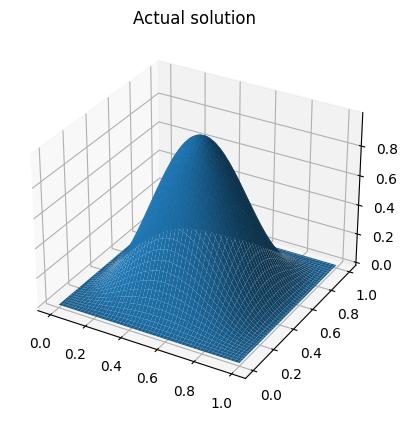

In [6]:
eps = 1
plot_graph(actual_soln(eps),'Actual solution')

Train Epoch: 0 
Total Loss: 857346.4375000000 	Criterion Loss: 857344.6875000000 	Boundary Condition Loss 1.732670
Train Epoch: 0 
Total Loss: 257908.7031250000 	Criterion Loss: 257798.1562500000 	Boundary Condition Loss 110.542168
Train Epoch: 0 
Total Loss: 45474.7187500000 	Criterion Loss: 45366.4960937500 	Boundary Condition Loss 108.223694
Train Epoch: 0 
Total Loss: 9585.2382812500 	Criterion Loss: 9540.6640625000 	Boundary Condition Loss 44.574635

After Epoch 0, 	 Actual solution loss: 1.5914781824



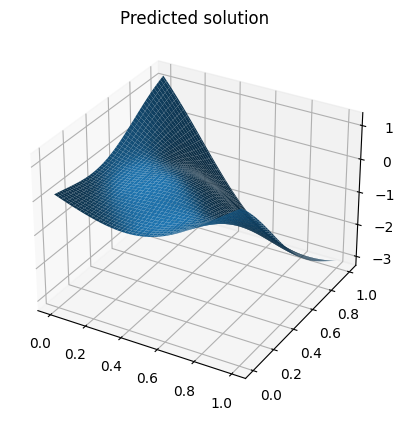

Train Epoch: 1 
Total Loss: 2179.5722656250 	Criterion Loss: 2144.1787109375 	Boundary Condition Loss 35.393475
Train Epoch: 1 
Total Loss: 643.3330078125 	Criterion Loss: 600.3210449219 	Boundary Condition Loss 43.011971
Train Epoch: 1 
Total Loss: 278.6290893555 	Criterion Loss: 236.8042449951 	Boundary Condition Loss 41.824860
Train Epoch: 1 
Total Loss: 268.4045104980 	Criterion Loss: 228.1116943359 	Boundary Condition Loss 40.292816

After Epoch 1, 	 Actual solution loss: 2.0587403753



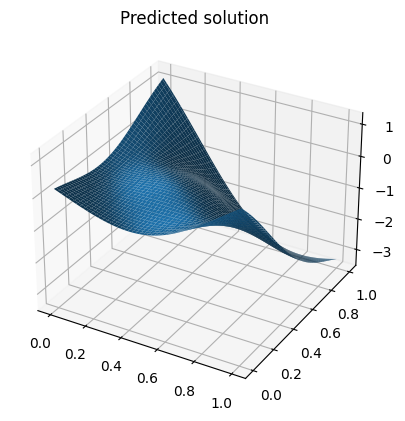

Train Epoch: 2 
Total Loss: 221.2185668945 	Criterion Loss: 181.9230651855 	Boundary Condition Loss 39.295498
Train Epoch: 2 
Total Loss: 238.7904357910 	Criterion Loss: 200.9022674561 	Boundary Condition Loss 37.888176
Train Epoch: 2 
Total Loss: 170.9975128174 	Criterion Loss: 135.1640319824 	Boundary Condition Loss 35.833477
Train Epoch: 2 
Total Loss: 185.6909484863 	Criterion Loss: 151.2391967773 	Boundary Condition Loss 34.451752

After Epoch 2, 	 Actual solution loss: 1.5154033521



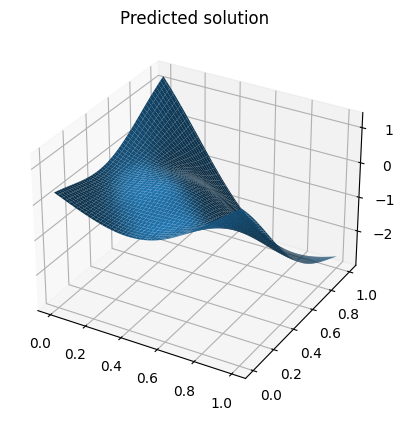

Train Epoch: 3 
Total Loss: 166.2682495117 	Criterion Loss: 133.5310668945 	Boundary Condition Loss 32.737190
Train Epoch: 3 
Total Loss: 196.1884765625 	Criterion Loss: 165.1008148193 	Boundary Condition Loss 31.087656
Train Epoch: 3 
Total Loss: 149.4878234863 	Criterion Loss: 120.1994171143 	Boundary Condition Loss 29.288401
Train Epoch: 3 
Total Loss: 244.1981658936 	Criterion Loss: 216.7099609375 	Boundary Condition Loss 27.488207

After Epoch 3, 	 Actual solution loss: 0.9863653666



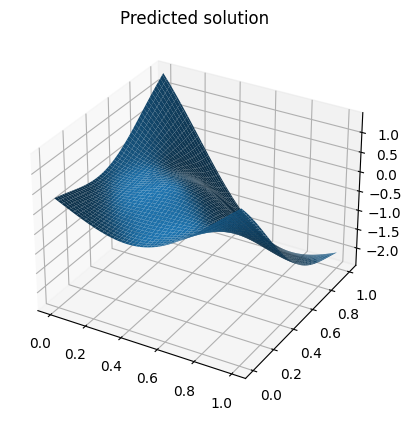

Train Epoch: 4 
Total Loss: 223.9377441406 	Criterion Loss: 197.8869628906 	Boundary Condition Loss 26.050781
Train Epoch: 4 
Total Loss: 119.5751037598 	Criterion Loss: 95.0016479492 	Boundary Condition Loss 24.573454
Train Epoch: 4 
Total Loss: 128.5241241455 	Criterion Loss: 105.3669738770 	Boundary Condition Loss 23.157148
Train Epoch: 4 
Total Loss: 88.0710754395 	Criterion Loss: 66.3594055176 	Boundary Condition Loss 21.711670

After Epoch 4, 	 Actual solution loss: 0.6215197039



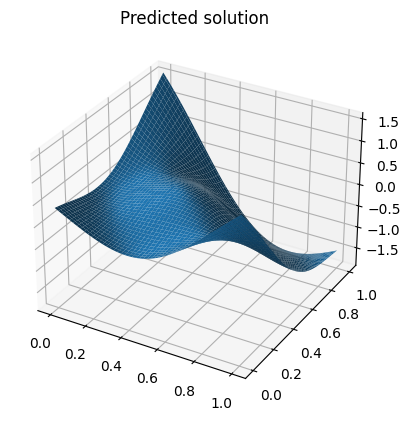

Train Epoch: 5 
Total Loss: 98.1665649414 	Criterion Loss: 77.8611068726 	Boundary Condition Loss 20.305462
Train Epoch: 5 
Total Loss: 86.8253402710 	Criterion Loss: 67.7486724854 	Boundary Condition Loss 19.076666
Train Epoch: 5 
Total Loss: 115.2306823730 	Criterion Loss: 96.9516830444 	Boundary Condition Loss 18.279003
Train Epoch: 5 
Total Loss: 609.1105957031 	Criterion Loss: 592.3656005859 	Boundary Condition Loss 16.744984

After Epoch 5, 	 Actual solution loss: 0.4330691508



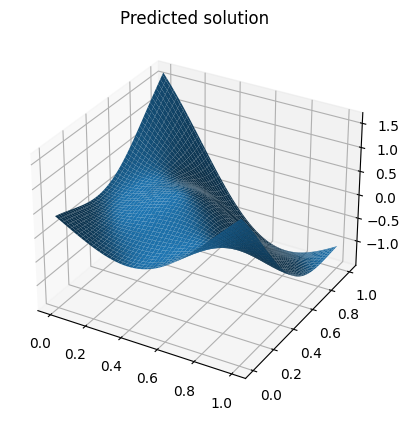

Train Epoch: 6 
Total Loss: 614.0559082031 	Criterion Loss: 596.6999511719 	Boundary Condition Loss 17.355951
Train Epoch: 6 
Total Loss: 197.7499694824 	Criterion Loss: 181.2728576660 	Boundary Condition Loss 16.477106
Train Epoch: 6 
Total Loss: 247.8380432129 	Criterion Loss: 231.9288330078 	Boundary Condition Loss 15.909207
Train Epoch: 6 
Total Loss: 225.7012481689 	Criterion Loss: 210.4037933350 	Boundary Condition Loss 15.297459

After Epoch 6, 	 Actual solution loss: 0.3231703145



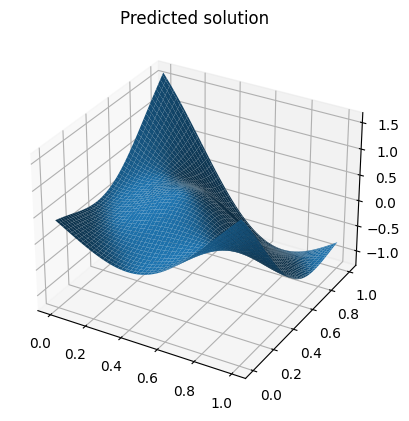

Train Epoch: 7 
Total Loss: 167.7936706543 	Criterion Loss: 152.7103424072 	Boundary Condition Loss 15.083328
Train Epoch: 7 
Total Loss: 94.1049575806 	Criterion Loss: 79.6661834717 	Boundary Condition Loss 14.438776
Train Epoch: 7 
Total Loss: 120.1563720703 	Criterion Loss: 106.6004409790 	Boundary Condition Loss 13.555935
Train Epoch: 7 
Total Loss: 56.9835853577 	Criterion Loss: 43.6116409302 	Boundary Condition Loss 13.371944

After Epoch 7, 	 Actual solution loss: 0.2574298365



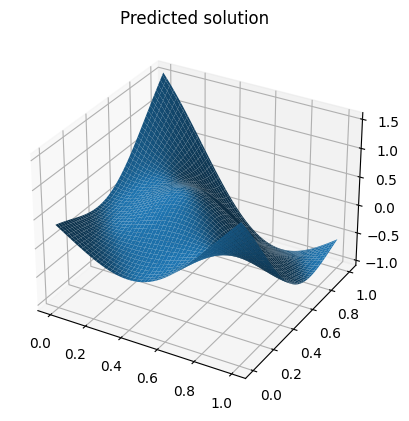

Train Epoch: 8 
Total Loss: 79.9243011475 	Criterion Loss: 67.2736816406 	Boundary Condition Loss 12.650621
Train Epoch: 8 
Total Loss: 256.5322570801 	Criterion Loss: 244.3946228027 	Boundary Condition Loss 12.137625
Train Epoch: 8 
Total Loss: 886.9102172852 	Criterion Loss: 874.8357543945 	Boundary Condition Loss 12.074434
Train Epoch: 8 
Total Loss: 441.3136291504 	Criterion Loss: 428.9055786133 	Boundary Condition Loss 12.408056

After Epoch 8, 	 Actual solution loss: 0.2507446092



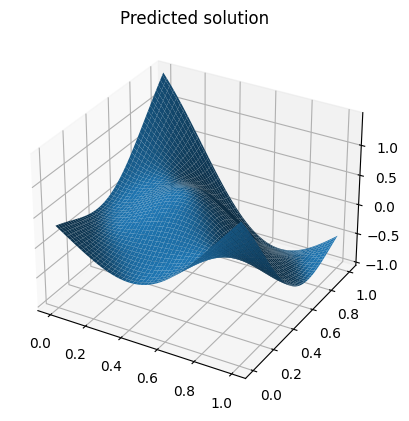

Train Epoch: 9 
Total Loss: 250.5060577393 	Criterion Loss: 238.1826782227 	Boundary Condition Loss 12.323386
Train Epoch: 9 
Total Loss: 82.6232147217 	Criterion Loss: 70.0353698730 	Boundary Condition Loss 12.587848
Train Epoch: 9 
Total Loss: 110.7597351074 	Criterion Loss: 98.5516662598 	Boundary Condition Loss 12.208066
Train Epoch: 9 
Total Loss: 48.8955917358 	Criterion Loss: 37.2812881470 	Boundary Condition Loss 11.614305

After Epoch 9, 	 Actual solution loss: 0.2263818245



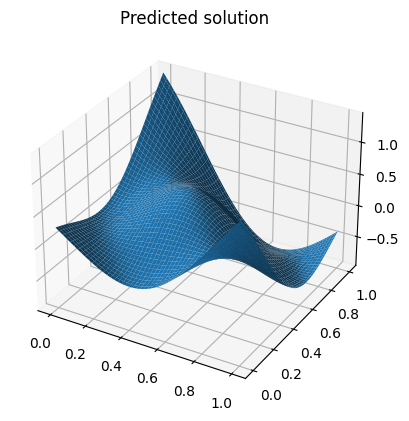

Train Epoch: 10 
Total Loss: 45.2941551208 	Criterion Loss: 33.9791145325 	Boundary Condition Loss 11.315041
Train Epoch: 10 
Total Loss: 54.6930999756 	Criterion Loss: 43.8006362915 	Boundary Condition Loss 10.892464
Train Epoch: 10 
Total Loss: 28.9202957153 	Criterion Loss: 18.4157276154 	Boundary Condition Loss 10.504568
Train Epoch: 10 
Total Loss: 68.4132232666 	Criterion Loss: 58.3231773376 	Boundary Condition Loss 10.090049

After Epoch 10, 	 Actual solution loss: 0.2046175834



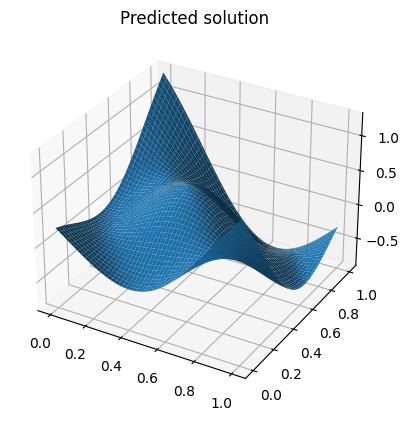

Train Epoch: 11 
Total Loss: 40.2508583069 	Criterion Loss: 30.4570446014 	Boundary Condition Loss 9.793814
Train Epoch: 11 
Total Loss: 350.9288024902 	Criterion Loss: 341.3317260742 	Boundary Condition Loss 9.597072
Train Epoch: 11 
Total Loss: 511.4854736328 	Criterion Loss: 502.3447265625 	Boundary Condition Loss 9.140736
Train Epoch: 11 
Total Loss: 99.6885910034 	Criterion Loss: 90.5657424927 	Boundary Condition Loss 9.122846

After Epoch 11, 	 Actual solution loss: 0.2097265220



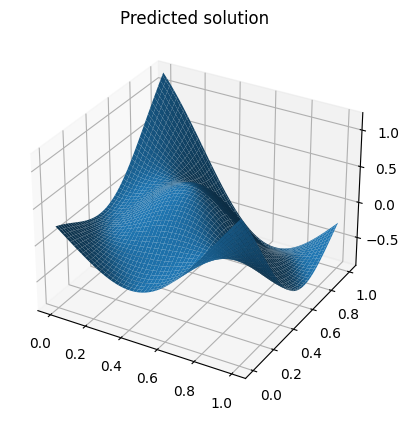

Train Epoch: 12 
Total Loss: 151.8658447266 	Criterion Loss: 142.5700531006 	Boundary Condition Loss 9.295790
Train Epoch: 12 
Total Loss: 206.5005187988 	Criterion Loss: 197.7887115479 	Boundary Condition Loss 8.711800
Train Epoch: 12 
Total Loss: 156.5844268799 	Criterion Loss: 147.5124664307 	Boundary Condition Loss 9.071961
Train Epoch: 12 
Total Loss: 175.8305358887 	Criterion Loss: 166.8543853760 	Boundary Condition Loss 8.976149

After Epoch 12, 	 Actual solution loss: 0.1818387259



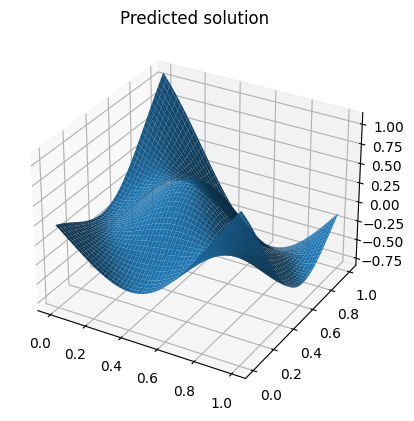

Train Epoch: 13 
Total Loss: 500.0675048828 	Criterion Loss: 491.2050170898 	Boundary Condition Loss 8.862496
Train Epoch: 13 
Total Loss: 63.0244522095 	Criterion Loss: 54.3865127563 	Boundary Condition Loss 8.637938
Train Epoch: 13 
Total Loss: 110.0312271118 	Criterion Loss: 101.7587738037 	Boundary Condition Loss 8.272452
Train Epoch: 13 
Total Loss: 82.2670135498 	Criterion Loss: 73.8564910889 	Boundary Condition Loss 8.410525

After Epoch 13, 	 Actual solution loss: 0.1698878274



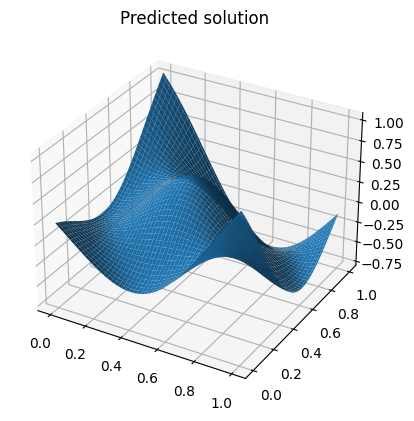

Train Epoch: 14 
Total Loss: 41.7116584778 	Criterion Loss: 33.7559051514 	Boundary Condition Loss 7.955754
Train Epoch: 14 
Total Loss: 148.2650146484 	Criterion Loss: 140.4770965576 	Boundary Condition Loss 7.787915
Train Epoch: 14 
Total Loss: 111.1230545044 	Criterion Loss: 103.3744277954 	Boundary Condition Loss 7.748625
Train Epoch: 14 
Total Loss: 435.2893981934 	Criterion Loss: 427.7701721191 	Boundary Condition Loss 7.519227

After Epoch 14, 	 Actual solution loss: 0.1750538917



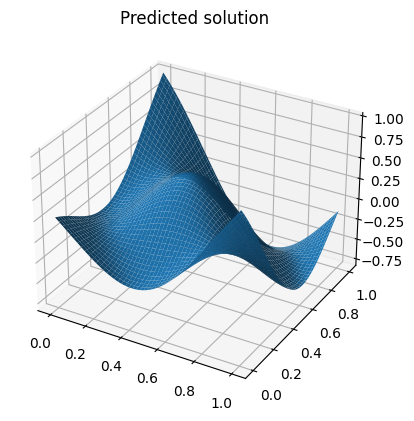

Train Epoch: 15 
Total Loss: 203.5635528564 	Criterion Loss: 195.9420776367 	Boundary Condition Loss 7.621476
Train Epoch: 15 
Total Loss: 120.8823318481 	Criterion Loss: 113.1546478271 	Boundary Condition Loss 7.727681
Train Epoch: 15 
Total Loss: 117.8741149902 	Criterion Loss: 110.3140563965 	Boundary Condition Loss 7.560061
Train Epoch: 15 
Total Loss: 142.6600646973 	Criterion Loss: 135.1368560791 	Boundary Condition Loss 7.523209

After Epoch 15, 	 Actual solution loss: 0.1444575481



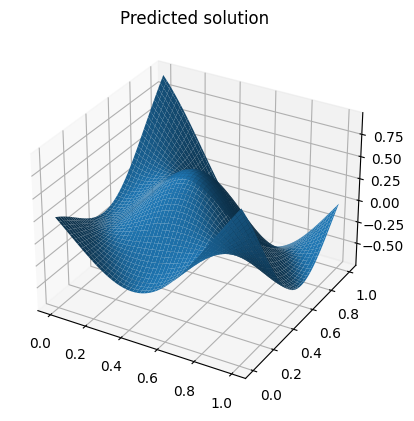

Train Epoch: 16 
Total Loss: 344.7119445801 	Criterion Loss: 337.6720275879 	Boundary Condition Loss 7.039925
Train Epoch: 16 
Total Loss: 329.0856933594 	Criterion Loss: 322.4311218262 	Boundary Condition Loss 6.654584
Train Epoch: 16 
Total Loss: 92.4940567017 	Criterion Loss: 85.5311126709 	Boundary Condition Loss 6.962941
Train Epoch: 16 
Total Loss: 42.7336616516 	Criterion Loss: 35.8107528687 	Boundary Condition Loss 6.922910

After Epoch 16, 	 Actual solution loss: 0.1472629563



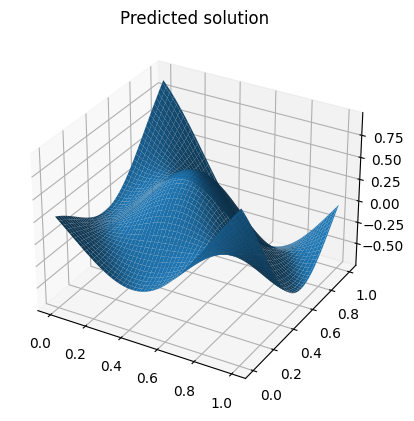

Train Epoch: 17 
Total Loss: 47.0794067383 	Criterion Loss: 40.2601623535 	Boundary Condition Loss 6.819242
Train Epoch: 17 
Total Loss: 25.1290149689 	Criterion Loss: 18.5269870758 	Boundary Condition Loss 6.602027
Train Epoch: 17 
Total Loss: 161.3107910156 	Criterion Loss: 154.9185791016 	Boundary Condition Loss 6.392205
Train Epoch: 17 
Total Loss: 132.9075164795 	Criterion Loss: 126.6579208374 	Boundary Condition Loss 6.249589

After Epoch 17, 	 Actual solution loss: 0.1359499053



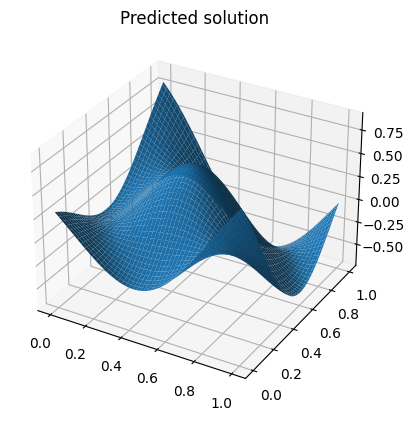

Train Epoch: 18 
Total Loss: 108.0745697021 	Criterion Loss: 102.0898590088 	Boundary Condition Loss 5.984713
Train Epoch: 18 
Total Loss: 160.0048065186 	Criterion Loss: 153.9787750244 	Boundary Condition Loss 6.026034
Train Epoch: 18 
Total Loss: 178.5345611572 	Criterion Loss: 172.4076232910 	Boundary Condition Loss 6.126937
Train Epoch: 18 
Total Loss: 221.9480438232 	Criterion Loss: 215.7964172363 	Boundary Condition Loss 6.151628

After Epoch 18, 	 Actual solution loss: 0.1412981823



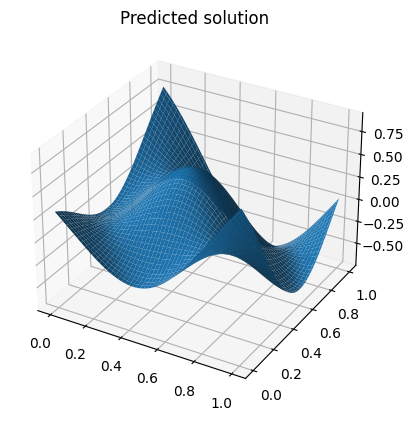

Train Epoch: 19 
Total Loss: 205.6127929688 	Criterion Loss: 199.2969360352 	Boundary Condition Loss 6.315853
Train Epoch: 19 
Total Loss: 113.1057052612 	Criterion Loss: 107.1888732910 	Boundary Condition Loss 5.916831
Train Epoch: 19 
Total Loss: 94.2638854980 	Criterion Loss: 88.2414321899 	Boundary Condition Loss 6.022453
Train Epoch: 19 
Total Loss: 295.3836669922 	Criterion Loss: 289.3758544922 	Boundary Condition Loss 6.007810

After Epoch 19, 	 Actual solution loss: 0.1238554414



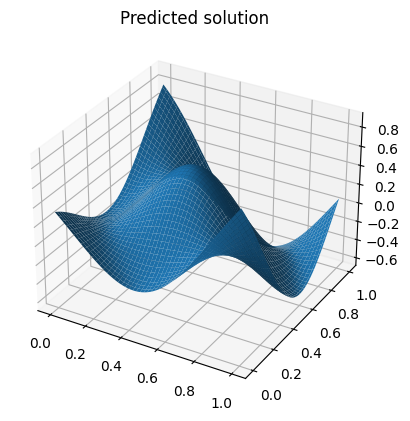

Train Epoch: 20 
Total Loss: 149.5317077637 	Criterion Loss: 143.6676635742 	Boundary Condition Loss 5.864050
Train Epoch: 20 
Total Loss: 161.7531433105 	Criterion Loss: 155.8703918457 	Boundary Condition Loss 5.882757
Train Epoch: 20 
Total Loss: 21.7450256348 	Criterion Loss: 16.0543003082 	Boundary Condition Loss 5.690726
Train Epoch: 20 
Total Loss: 20.7905254364 	Criterion Loss: 15.1672744751 	Boundary Condition Loss 5.623250

After Epoch 20, 	 Actual solution loss: 0.1161916875



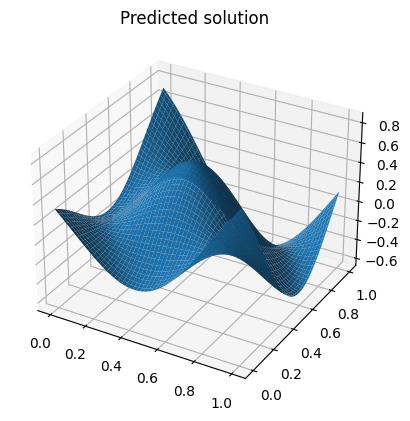

Train Epoch: 21 
Total Loss: 20.7016716003 	Criterion Loss: 15.1525726318 	Boundary Condition Loss 5.549099
Train Epoch: 21 
Total Loss: 95.1607208252 	Criterion Loss: 89.8321380615 	Boundary Condition Loss 5.328586
Train Epoch: 21 
Total Loss: 227.9762115479 	Criterion Loss: 222.7180480957 	Boundary Condition Loss 5.258159
Train Epoch: 21 
Total Loss: 80.8754806519 	Criterion Loss: 75.5794982910 	Boundary Condition Loss 5.295986

After Epoch 21, 	 Actual solution loss: 0.1172166601



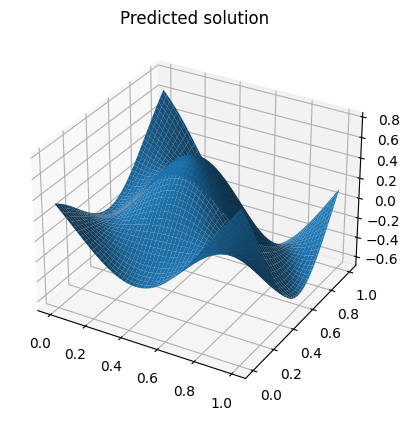

Train Epoch: 22 
Total Loss: 327.6534729004 	Criterion Loss: 322.3981323242 	Boundary Condition Loss 5.255348
Train Epoch: 22 
Total Loss: 104.0401840210 	Criterion Loss: 98.9581146240 	Boundary Condition Loss 5.082069
Train Epoch: 22 
Total Loss: 43.9878692627 	Criterion Loss: 38.9874191284 	Boundary Condition Loss 5.000448
Train Epoch: 22 
Total Loss: 46.7763442993 	Criterion Loss: 41.7554512024 	Boundary Condition Loss 5.020895

After Epoch 22, 	 Actual solution loss: 0.0985244793



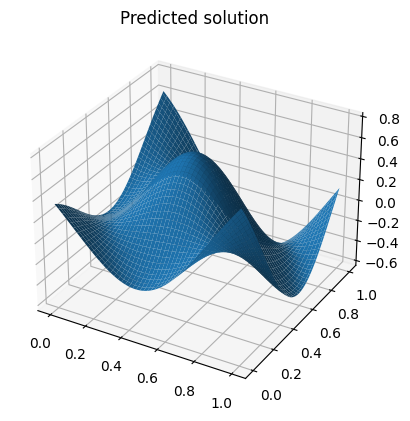

Train Epoch: 23 
Total Loss: 315.5705871582 	Criterion Loss: 310.8398437500 	Boundary Condition Loss 4.730741
Train Epoch: 23 
Total Loss: 191.2166290283 	Criterion Loss: 186.5989837646 	Boundary Condition Loss 4.617648
Train Epoch: 23 
Total Loss: 194.8582916260 	Criterion Loss: 190.2581481934 	Boundary Condition Loss 4.600146
Train Epoch: 23 
Total Loss: 42.4828643799 	Criterion Loss: 37.8026046753 	Boundary Condition Loss 4.680261

After Epoch 23, 	 Actual solution loss: 0.0988050462



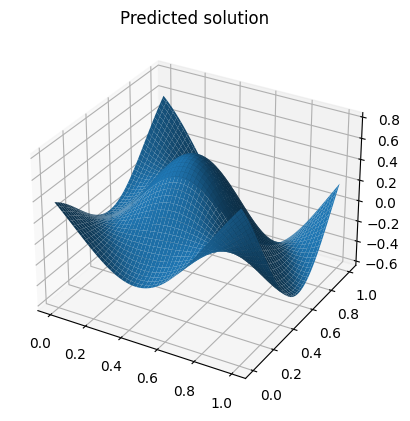

Train Epoch: 24 
Total Loss: 145.3103485107 	Criterion Loss: 140.6243286133 	Boundary Condition Loss 4.686013
Train Epoch: 24 
Total Loss: 69.8906707764 	Criterion Loss: 65.4176025391 	Boundary Condition Loss 4.473071
Train Epoch: 24 
Total Loss: 178.5086059570 	Criterion Loss: 174.0242309570 	Boundary Condition Loss 4.484382
Train Epoch: 24 
Total Loss: 282.3207092285 	Criterion Loss: 277.8638610840 	Boundary Condition Loss 4.456855

After Epoch 24, 	 Actual solution loss: 0.1008803851



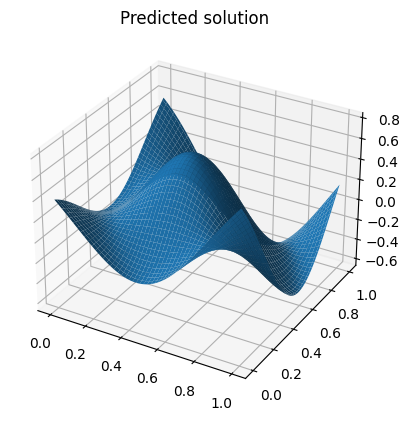

Train Epoch: 25 
Total Loss: 396.9139709473 	Criterion Loss: 392.3023986816 	Boundary Condition Loss 4.611561
Train Epoch: 25 
Total Loss: 237.7061462402 	Criterion Loss: 233.0573120117 	Boundary Condition Loss 4.648837
Train Epoch: 25 
Total Loss: 37.2463188171 	Criterion Loss: 32.6318244934 	Boundary Condition Loss 4.614496
Train Epoch: 25 
Total Loss: 89.6505966187 	Criterion Loss: 85.1384735107 	Boundary Condition Loss 4.512124

After Epoch 25, 	 Actual solution loss: 0.0918722551



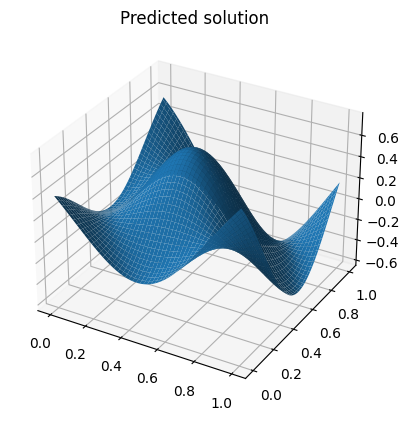

Train Epoch: 26 
Total Loss: 40.0100784302 	Criterion Loss: 35.6517868042 	Boundary Condition Loss 4.358293
Train Epoch: 26 
Total Loss: 56.2039222717 	Criterion Loss: 51.8838424683 	Boundary Condition Loss 4.320079
Train Epoch: 26 
Total Loss: 71.5699615479 	Criterion Loss: 67.2259063721 	Boundary Condition Loss 4.344051
Train Epoch: 26 
Total Loss: 122.2410202026 	Criterion Loss: 118.0412063599 	Boundary Condition Loss 4.199814

After Epoch 26, 	 Actual solution loss: 0.0910632074



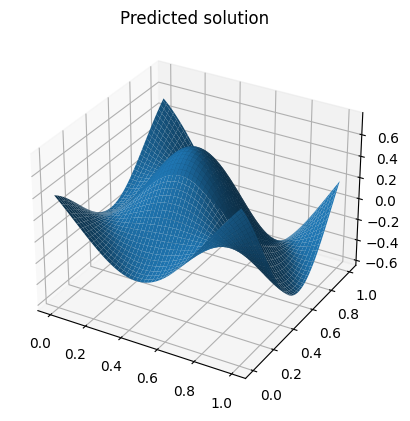

Train Epoch: 27 
Total Loss: 93.1434249878 	Criterion Loss: 88.9592590332 	Boundary Condition Loss 4.184167
Train Epoch: 27 
Total Loss: 53.6764335632 	Criterion Loss: 49.4569549561 	Boundary Condition Loss 4.219477
Train Epoch: 27 
Total Loss: 94.5210418701 	Criterion Loss: 90.2975387573 	Boundary Condition Loss 4.223507
Train Epoch: 27 
Total Loss: 83.1430358887 	Criterion Loss: 78.9837951660 	Boundary Condition Loss 4.159242

After Epoch 27, 	 Actual solution loss: 0.0956523838



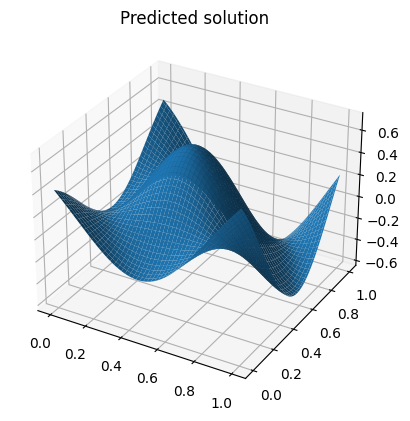

Train Epoch: 28 
Total Loss: 501.5094299316 	Criterion Loss: 497.3079223633 	Boundary Condition Loss 4.201493
Train Epoch: 28 
Total Loss: 460.8328857422 	Criterion Loss: 456.6939086914 	Boundary Condition Loss 4.138974
Train Epoch: 28 
Total Loss: 107.4628906250 	Criterion Loss: 103.2355651855 	Boundary Condition Loss 4.227325
Train Epoch: 28 
Total Loss: 48.7345581055 	Criterion Loss: 44.5548400879 	Boundary Condition Loss 4.179718

After Epoch 28, 	 Actual solution loss: 0.0945147770



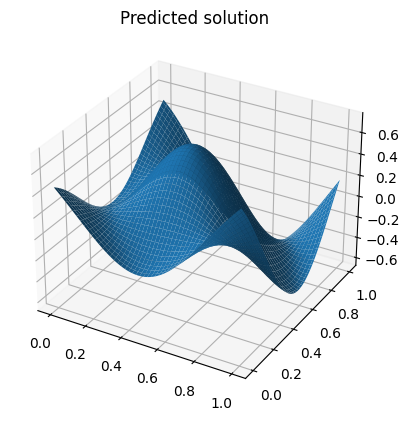

Train Epoch: 29 
Total Loss: 84.5676345825 	Criterion Loss: 80.3887329102 	Boundary Condition Loss 4.178901
Train Epoch: 29 
Total Loss: 94.4681701660 	Criterion Loss: 90.4225921631 	Boundary Condition Loss 4.045575
Train Epoch: 29 
Total Loss: 56.9324188232 	Criterion Loss: 52.8728294373 	Boundary Condition Loss 4.059591
Train Epoch: 29 
Total Loss: 49.9956169128 	Criterion Loss: 46.1099586487 	Boundary Condition Loss 3.885658

After Epoch 29, 	 Actual solution loss: 0.0831307733



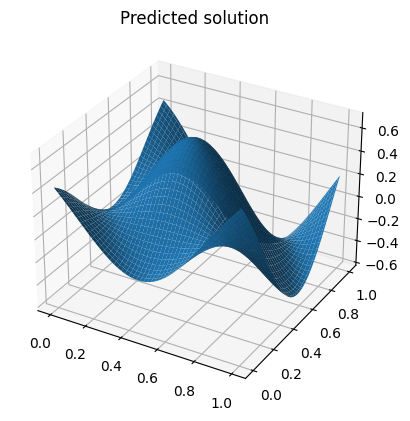

Train Epoch: 30 
Total Loss: 37.5923957825 	Criterion Loss: 33.8165702820 	Boundary Condition Loss 3.775826
Train Epoch: 30 
Total Loss: 31.3129062653 	Criterion Loss: 27.6109809875 	Boundary Condition Loss 3.701926
Train Epoch: 30 
Total Loss: 442.1968383789 	Criterion Loss: 438.5493164062 	Boundary Condition Loss 3.647512
Train Epoch: 30 
Total Loss: 376.2638244629 	Criterion Loss: 372.4483032227 	Boundary Condition Loss 3.815512

After Epoch 30, 	 Actual solution loss: 0.0801380982



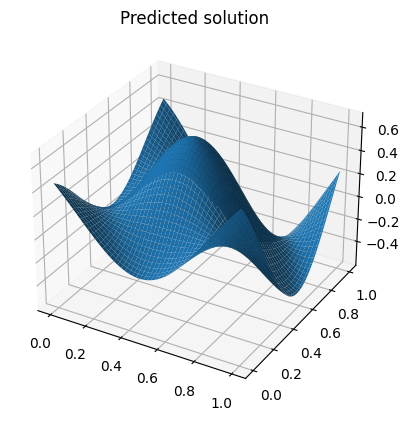

Train Epoch: 31 
Total Loss: 83.9885864258 	Criterion Loss: 80.1578521729 	Boundary Condition Loss 3.830732
Train Epoch: 31 
Total Loss: 93.3011703491 	Criterion Loss: 89.3827133179 	Boundary Condition Loss 3.918460
Train Epoch: 31 
Total Loss: 66.1532135010 	Criterion Loss: 62.2266807556 	Boundary Condition Loss 3.926532
Train Epoch: 31 
Total Loss: 23.8845348358 	Criterion Loss: 19.9797306061 	Boundary Condition Loss 3.904804

After Epoch 31, 	 Actual solution loss: 0.0769263300



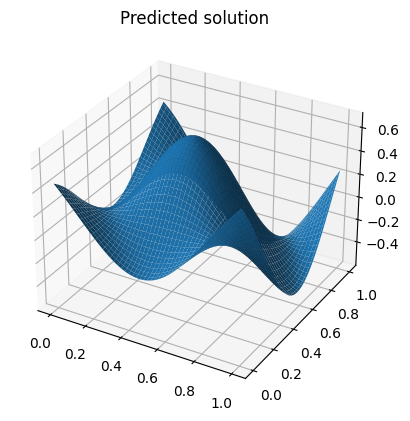

Train Epoch: 32 
Total Loss: 33.5996704102 	Criterion Loss: 29.8611087799 	Boundary Condition Loss 3.738564
Train Epoch: 32 
Total Loss: 104.4179763794 	Criterion Loss: 100.7659225464 	Boundary Condition Loss 3.652052
Train Epoch: 32 
Total Loss: 100.2469406128 	Criterion Loss: 96.5753326416 	Boundary Condition Loss 3.671611
Train Epoch: 32 
Total Loss: 117.3598937988 	Criterion Loss: 113.6425476074 	Boundary Condition Loss 3.717345

After Epoch 32, 	 Actual solution loss: 0.0725755843



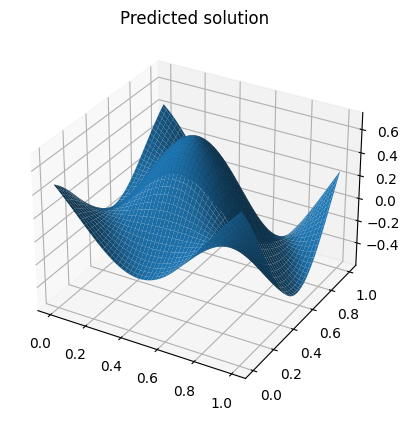

Train Epoch: 33 
Total Loss: 72.2195663452 	Criterion Loss: 68.5676040649 	Boundary Condition Loss 3.651961
Train Epoch: 33 
Total Loss: 350.1659851074 	Criterion Loss: 346.5741882324 	Boundary Condition Loss 3.591782
Train Epoch: 33 
Total Loss: 228.4769287109 	Criterion Loss: 224.7358398438 	Boundary Condition Loss 3.741096
Train Epoch: 33 
Total Loss: 58.3271141052 	Criterion Loss: 54.6784782410 	Boundary Condition Loss 3.648636

After Epoch 33, 	 Actual solution loss: 0.0756481008



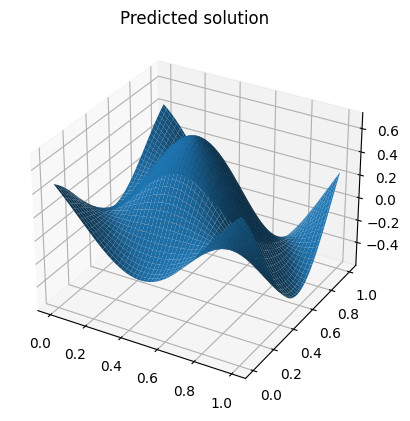

Train Epoch: 34 
Total Loss: 16.6409358978 	Criterion Loss: 13.1153831482 	Boundary Condition Loss 3.525553
Train Epoch: 34 
Total Loss: 13.9416418076 	Criterion Loss: 10.4283275604 	Boundary Condition Loss 3.513314
Train Epoch: 34 
Total Loss: 71.0756759644 	Criterion Loss: 67.6027069092 	Boundary Condition Loss 3.472973
Train Epoch: 34 
Total Loss: 197.1865692139 	Criterion Loss: 193.7131042480 	Boundary Condition Loss 3.473466

After Epoch 34, 	 Actual solution loss: 0.0758262643



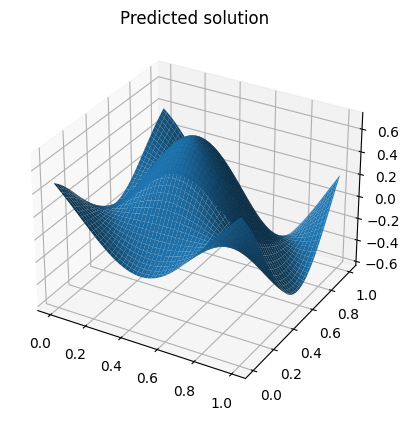

Train Epoch: 35 
Total Loss: 134.9247283936 	Criterion Loss: 131.5411987305 	Boundary Condition Loss 3.383524
Train Epoch: 35 
Total Loss: 198.5671997070 	Criterion Loss: 195.1325683594 	Boundary Condition Loss 3.434637
Train Epoch: 35 
Total Loss: 93.2439727783 	Criterion Loss: 89.8601760864 	Boundary Condition Loss 3.383797


KeyboardInterrupt: 

In [7]:
epochs = 1000
device = torch.device("cpu")

batchsize = 128 
learning_rate = 1e-3
batch_flag = True
batch_size = 128

output = train(device,x,y,xb,yb,eps,learning_rate,epochs,batch_flag,batch_size)

In [1]:
z = output.detach().numpy()
plot_graph(z,"Predicted Solution")
plot_graph(actual_soln(eps),"Actual Solution")

NameError: name 'output' is not defined